In [ ]:
# coding: utf-8
get_ipython().magic(u'matplotlib notebook')

"""
Isolated triple vs triple around SMBH
Alessandro Alberto Trani 14/06/2018
"""

# comment these lines if you're using python3
from __future__ import (absolute_import, division, print_function)
# from builtins import *

from amuse.units import (nbody_system, units, constants, quantities)
from amuse.community.hermite4 import Hermite
from amuse.datamodel import Particles
from amuse.couple import bridge
import matplotlib.ticker as mtick

from amuse.datamodel.particles import Channels
# from amuse.ext.molecular_cloud import molecular_cloud
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class SMBHGravityCode(object):
    def __init__(self,
                 bh_mass=4.31e6 | units.MSun,
                 position=[0, 0, 0] | units.parsec):
        self.bh_mass = bh_mass
        self.position = position

    def get_gravity_at_point(self, eps, x, y, z):
        dx = x - self.position.x
        dy = y - self.position.y
        dz = z - self.position.z
        radius = (dx*dx + dy*dy + dz*dz).sqrt()
        radius3 = radius*radius*radius
        fr = -constants.G*self.bh_mass/radius3
        ax = fr*dx
        ay = fr*dy
        az = fr*dz
        return ax, ay, az

    def get_potential_at_point(self, eps, x, y, z):
        dx = x - self.position.x
        dy = y - self.position.y
        dz = z - self.position.z
        radius = (dx*dx + dy*dy + dz*dz).sqrt()
        phi = -constants.G*self.bh_mass/radius
        return phi

    def stop(self):
        pass

    @property
    def kinetic_energy(self):
        return quantities.zero

    @property
    def potential_energy(self):
        return quantities.zero

    @property
    def thermal_energy(self):
        return quantities.zero

In [ ]:
# creating triple system
sys = Particles(3, mass=30 | units.MSun)
sys.position = [[0.3070640329532462, 0.2392405139186416, 0],
                [-0.3865927585370948, -0.10634061110834962, 0],
                [0.27952872558384859, -0.4328999028102919, 0]] | units.AU
sys.velocity = [[23.518569826682455, 10.52227851919019, 0],
                [-20.74623746218285, -22.52084408611801, 0],
                [6.227667635500401, 12.998565566927823, 0]] | units.AU/units.yr

In [ ]:
#  give triple system orbital velocity around SMBH
r = 0.001 | units.parsec
rpc = r.value_in(units.parsec)
bh_mass = 4.31e6 | units.MSun
sys.position += (1, 0, 0) * r
sys.velocity += (0, 1, 0) * (constants.G*bh_mass/r).sqrt()

# print(sys)
conv = nbody_system.nbody_to_si(1 | units.MSun, 1 | units.AU)

code = Hermite(conv, mode='mpi', )
code.particles.add_particles(sys)

<IPython.core.display.Javascript object>


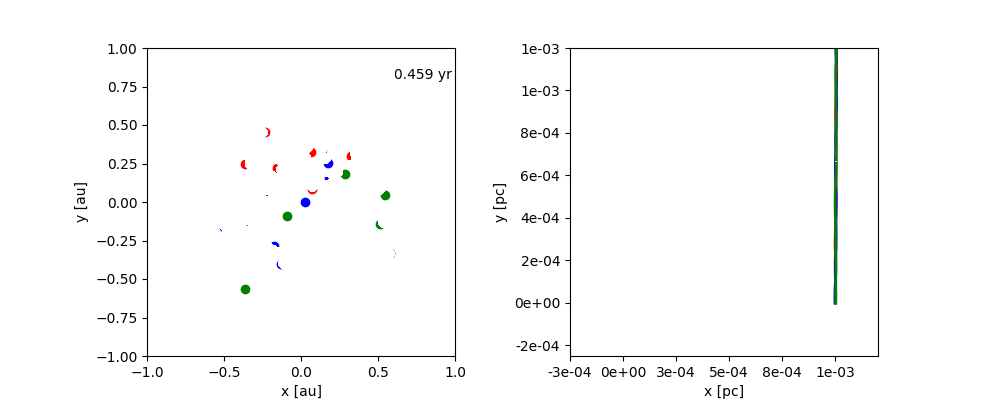

In [ ]:
# adding channels to copy particle sets to our framework
channel = Channels()
channel.add_channel(code.particles.new_channel_to(sys))

# plotting
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.set_xlabel('x [pc]')
ax2.set_ylabel('y [pc]')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%1.0e'))
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%1.0e'))

plt.ion()
fig.show()
fig.canvas.draw()

xs = np.array(
        [
            [sys[0].x.value_in(units.parsec)],
            [sys[1].x.value_in(units.parsec)],
            [sys[2].x.value_in(units.parsec)],
            ]
        )
ys = np.array(
        [
            [sys[0].y.value_in(units.parsec)],
            [sys[1].y.value_in(units.parsec)],
            [sys[2].y.value_in(units.parsec)],
            ]
        )
# plot empty line to generate line object
l1, = ax2.plot(xs[0], ys[0], lw='2', c='red')
l2, = ax2.plot(xs[1], ys[1], lw='2', c='blue')
l3, = ax2.plot(xs[2], ys[2], lw='2', c='green')
p1, = ax.plot(
        sys[0].x.value_in(units.AU),
        sys[0].y.value_in(units.AU),
        lw='2', c='red', marker='o', ls='',
        )
p2, = ax.plot(
        sys[1].x.value_in(units.AU),
        sys[1].y.value_in(units.AU),
        lw='2', c='blue', marker='o', ls='',
        )
p3, = ax.plot(
        sys[2].x.value_in(units.AU),
        sys[2].y.value_in(units.AU),
        lw='2', c='green', marker='o', ls='',
        )

#  adding SMBH potential?
SMBH = False
if(SMBH):
    bh_code = SMBHGravityCode()
    brd = bridge.Bridge(timestep=1e-4 | units.yr)
    brd.add_system(code, [bh_code])
    ax2.scatter(0, 0, marker='X', s=100, label='SMBH', c='black')
else:
    brd = code

# evolve the system
tend = 10 | units.yr
dtime = 0.001 | units.yr
time = 0 | units.yr
tl = ax.text(0.6, 0.8, "{:s}".format(time.as_quantity_in(units.yr)))
while time < tend:
    time += dtime
    brd.evolve_model(time)
    # print("evolved to time {:s}".format(time))
    channel.copy()

    ax2.set_ylim(-rpc/4, rpc*1.2)
    ax2.set_xlim(-rpc/4, rpc*1.2)
    ax2.set_aspect('equal')
    xs = np.append(
            xs,
            [
                [sys[0].x.value_in(units.parsec)],
                [sys[1].x.value_in(units.parsec)],
                [sys[2].x.value_in(units.parsec)],
                ],
            axis=1,
            )
    ys = np.append(
            ys,
            [
                [sys[0].y.value_in(units.parsec)],
                [sys[1].y.value_in(units.parsec)],
                [sys[2].y.value_in(units.parsec)],
                ],
            axis=1)
    l1.set_data(xs[0], ys[0])
    l2.set_data(xs[1], ys[1])
    l3.set_data(xs[2], ys[2])

    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)
    ax.set_xlabel('x [au]')
    ax.set_ylabel('y [au]')
    ax.set_aspect('equal')
    sys.move_to_center()
    p1.set_data(sys[0].x.value_in(units.AU), sys[0].y.value_in(units.AU))
    p2.set_data(sys[1].x.value_in(units.AU), sys[1].y.value_in(units.AU))
    p3.set_data(sys[2].x.value_in(units.AU), sys[2].y.value_in(units.AU))
    tl.set_text("{:s}".format(time.as_quantity_in(units.yr)))
    fig.canvas.draw()

brd.stop()